# **Non-negative Matrix Factorization - An Implementation and Experimentation**
### CSC 466-1 Knowledge Discovery from Data, Winter 2020 - Final Project
#### Andrew Kesheshian, Griffin Johnson, Quinn Coleman

## **Background**
Non-negative matrix factorization (NMF) is an unsupervised machine learning technique created by [Lee & Seung](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf) in 1999. It is a versatile algorithm because of its ability to make a parts-based-representation of its input data. What enables this parts-based-representation is the constraint that NMF's input data must be quantitative with no negative values. 

### **How it Works**
Given a non-negative matrix ***V*** of dimension *f* ✕ *t*, the algorithm learns two non-negative matrices: ***W*** of dimension *f* ✕ *k* and ***H*** of dimension *k* ✕ *t*, where k < minimum(f,t). ***W*** and ***H*** are approximate factors of ***V***, thus when they are multiplied together, they create an approximation of the original matrix called ***V'***.

- ***V*** is the original data
    - t columns of f-dimensional data
    - Each column is a sample, each row is a feature
- ***W*** is the basis vectors (or dictionary matrix)
    - A linear combination of these approximates any sample in V
    - Each column is called a basis vector
- ***H*** is the activations
    - Each set of activations encodes a linear combination of all basis vectors, and corresponds to a sample in V
    - Each column is called a set of activations (or weights or gains)

To put it simply, basis vectors are like the building blocks to create any sample in our input data, and an activation tells us how much of each building block to use to recreate a sample.

![NMF](NMF.png)

Figure by Qwertyus - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=29114677

NMF has many uses. It can naturally be used for data compression and approximation - if k is small enough, like k = 2 in the figure above, ***W*** and ***H*** take up less space than the original data ***V***. It also has data-specific uses like source-seperation for audio data or topic extraction for textual data. A use of NMF we'll explore is **dimensionality reduction**. 

### **Dimensionality Reduction**
Dimensionality reduction is the task of taking a dataset with many dimensions (or features), and transforming it into a dataset with fewer dimensions while losing the least amount of information possible.

We already learned a dimensionality reduction technique in class: Principal Components Analysis (PCA). The principal components (PCs) in PCA describe the axes orthogonal to each other that run in the direction of greatest variance in the data. Thus, these principal components can describe the data in lower dimension.

![PCA](PCA.png)

Figure by https://medium.com/@TheDataGyan/dimensionality-reduction-with-pca-and-t-sne-in-r-2715683819

Like the principal components of PCA, the basis vectors of NMF accomplish the same thing. If you think about it, basis vectors in the linear algebra sense are unit vectors that describe a vector space. To "describe a vector space" means any possible vector can be made with a linear combination of these basis vectors. Principal components are like specifically-designed basis vectors for losing the least amount of information possible. For example, in the figure above, if a dataset is being dimension-reduced by only 1 dimension, information will be lost but only on the axis of least variance (PC1 and PC2 are the axes of greatest variance).

So in NMF, as long we choose a k-value that is less than the number of dimensions in our dataset, we'll create k basis vectors, and reduce our dataset down to k dimensions. Since each datapoint in a dimension-reduced dataset is a linear combination of basis vectors, our dimension-reduced dataset is simply the matrix ***H***.

## **Implementation**
In order to make NMF, we frame an optimization problem. This optimization problem is about minimizing the distance/error from the product ***WH*** to ***V***. The implementation of NMF we are using is derived from a specific distance measurement called Kullback-Leibler (KL) Divergence. KL Divergence mathematically allows us to create two multiplicative update formulas, one for each of the matrices: ***W*** and ***H***.

In this algorithm, ***W*** and ***H*** are initialized to random-valued matrices in an unsupervised manner, and ***V*** is input. Then, for a predetermined number of iterations (usually 100-200 until convergence), the multiplicative updates are applied to ***W*** and ***H*** in succession until their matrix product doesn't approximate the original data any much better with continuing iterations. The figure below sums up this algorithm as "KL-NMF".

![NMF learn loop](NMF_Learn_Loop.png)

Figure by https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf

For dimensionality reduction, one more step to take is to normalize the basis vector matrix after initialization and each update. This normalization insures that the basis vectors remain unit vectors, as the only thing that matters is their orientation. With that said, let's code this below. We'll put this algorithm inside the primary method of our NMF class.

In [1]:
import numpy as np
from sklearn.preprocessing import normalize


class OurNMF:
    def __init__(self, n_components, learn_iter=200):
        self.n_components_ = n_components
        self.learn_iter_ = learn_iter
        
    # Private method - core functionality
    def __nmf(self, input_df):
        input_matrix = input_df.to_numpy().T
        activations = np.random.rand(self.n_components_, input_matrix.shape[1])
        basis_vectors = np.random.rand(input_matrix.shape[0], self.n_components_)
        basis_vectors = normalize(basis_vectors)
        ones = np.ones(input_matrix.shape)
    
        for i in range(self.learn_iter_):
            activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
            basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
            
            activations = np.nan_to_num(activations)
            basis_vectors = np.nan_to_num(basis_vectors)
            basis_vectors = normalize(basis_vectors)
            
        return basis_vectors.T, activations.T
    
    # Public methods
    def fit(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        
    def fit_transform(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        return self.trans_vals_

    def test_fit(self, input_df):
        return self.__nmf(input_df)

## **Validate our Implementation**
Let's validate our implementation of NMF by comparing its results with the NMF method provided by a trusted and widely-used machine learning library.

This library is called [scikit-learn](https://scikit-learn.org/stable/) and its NMF documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

***Note -- Scikit-Learn Documentation Error:***
On the NMF documentation page, variable names *W* and *H* are swapped which can be very **misleading**. They call *W* the transformed data, and *H* the factorization matrix (dictionary elements). In reality, *W* is this factorization matrix, and *H* is the transformed data *(no documentation is perfect, even for scikit-learn)*.

#### **Dataset Creation**
To begin, let's make a dataset for our NMFs. We use another python library, [pandas](https://pandas.pydata.org/), to handle datasets.

In [2]:
import pandas as pd

dummy_data = [{'A': 1.00, 'B': 'K', 'C': 3, 'D': 9, 'E': 43.76, 'ans': 1},
              {'A': 0.99, 'B': 'L', 'C': 3, 'D': 8, 'E': 43.45, 'ans': 0},
              {'A': 0.54, 'B': 'M', 'C': 0, 'D': 23, 'E': 54.65, 'ans': 1},
              {'A': 1.00, 'B': 'M', 'C': 0, 'D': 12, 'E': 40.15, 'ans': 0},
              {'A': 0.32, 'B': 'L', 'C': 1, 'D': 12, 'E': 89.04, 'ans': 1},
              {'A': 0.43, 'B': 'L', 'C': 4, 'D': 11, 'E': 49.04, 'ans': 0},
              {'A': 0.99, 'B': 'M', 'C': 1, 'D': 10, 'E': 34.54, 'ans': 0}]

dummy_df = pd.DataFrame(dummy_data)
# Transform categorical features ('B') into quantitative ones ('K', 'L', 'M') via get_dummies (one-hot encoding)
quant = pd.get_dummies(dummy_df['B'])
labels = dummy_df['ans']
dummy_df = dummy_df.drop('B', axis=1).drop('ans', axis=1)
dummy_df = pd.concat((dummy_df, quant, labels), axis=1)
dummy_df

,A,C,D,E,K,L,M,ans
0,1.00,3,9,43.76,1,0,0,1
1,0.99,3,8,43.45,0,1,0,0
2,0.54,0,23,54.65,0,0,1,1
3,1.00,0,12,40.15,0,0,1,0
4,0.32,1,12,89.04,0,1,0,1
5,0.43,4,11,49.04,0,1,0,0
6,0.99,1,10,34.54,0,0,1,0


#### **Comparison**
A good way to see if our NMF works is by performing a common use case for dimensionality reduction: visualizing data.

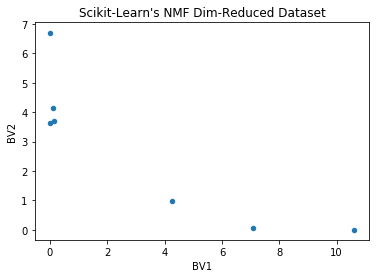

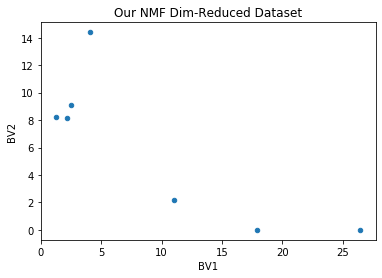

In [3]:
%matplotlib inline
from sklearn.decomposition import NMF

sklearn_nmf = NMF(n_components=2, init='random', solver='mu', beta_loss='kullback-leibler')
our_nmf = OurNMF(n_components=2)

sklearn_trans_df = pd.DataFrame(sklearn_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])
our_trans_df = pd.DataFrame(our_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])

sklearn_trans_df.plot.scatter(x='BV1', y='BV2', title='Scikit-Learn\'s NMF Dim-Reduced Dataset')
our_trans_df.plot.scatter(x='BV1', y='BV2', title='Our NMF Dim-Reduced Dataset')

This is great, our NMF works! 🎉🎉 Since the data on both charts look similar, it seems that both our and scikit-learn's NMF find the same way to represent this data in lower dimension.

*Note -- if you don't see a similarity between plots and the axes look flipped:* Run the previous code cell 1-2 more times until they match. This happens because in NMF each basis vector equally contributes to recreating the dataset, so their ordering isn't meaningful, thus not needing consistency. We just want to see when the two basis vectors from our NMF is in the same order as scikit-learn NMF's two basis vectors - when this happens, the transformed values corresponding to a basis vector will appear on the same axis as the other chart's axis.

## **Experimentation**

Let's now use our NMF implementation to see how NMF compares to PCA.

#### **Experiment 1: Comparing the Guts of NMF and PCA**

In order to evaluate how our NMF algorithm compares to other dimensionality reduction algorithms, we can compare our implementation to PCA. When we are talking about two or less dimensions comparing basis vector becomes more difficult.  One way to do this is to use a correlation test between pairs of basis vectors from NMF and PCA respectively.

For a correlation test, a common choice is the Pearson Correlation test which gives us a value between -1 and 1 that describes the linear correlated relationship of two vectors.

The actual formula for calculating Pearson Correlation is as follows, 
$R_{XY} = \frac{\sum_{i=1}^n(X_i - \overline{X})(Y_i - \overline{Y})}{\sqrt{\sum_{i=1}^n(X_i - \overline{X})^2}\sqrt{\sum_{i=1}^n(Y_i - \overline{Y})^2}}$

What all this math is doing is basically dividing the covariance by the product of the standard deviations for our given vectors. We can use scipy's implementation of the pearson correlation test by importing the given module.

In [8]:
# my various imports
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize

In [9]:
def correlate(nmf_i, pca_i):
    # we only want the coefficient
    return pearsonr(nmf_i, pca_i)[0] 

We also need a set of control data to run our tests against. Let's write a quick function to generate a square matrix of positive values ranging from 1 - 10.

In [10]:
# generates a matrix of N x N w/ values (1-10)
def generateV(N=25):
    return 10 * np.random.random_sample((N, N))

Now let's write our function that compares NMF to PCA using the pearson correlation test function we just wrote.

In [11]:
def compareNMFtoPCA(V):
    Vn = np.array(V)
    F = len(V[0]) # feature count
    pair_matrices = []
    df = []
    for i in range(F,1,-1):
        p = PCA(n_components=i).fit(Vn).components_
        pairs = [[0]*i]*i 
        our_nmf = OurNMF(n_components=i)
        w, h = our_nmf.test_fit(pd.DataFrame(V))
        sum = 0.0        
        for nmf_i in range(i):
            for pca_i in range(i):
                sum += correlate(w[nmf_i], p[pca_i])
                pairs[nmf_i][pca_i] = correlate(w[nmf_i], p[pca_i])
        df.append([(sum / i)])
        pair_matrices.append(pairs)
    return pd.DataFrame(df, columns=["Correlation"]), pair_matrices

Our function at each iteration of dimensionality reduction, constructs every possible pair of basis vectors from both NMF and PCA. The function then compares each pair of basis vectors using pearson's correlation test. An average correlation value accross all pairs is retrieved for each iteration of dimensionality reduction. This value is meant to signify how closely each algorithm's produced basis vector is at a particular dimension.

In [14]:
V = generateV(N=50)
# outputs list of pair matrices containing pearson correlation values 
# for each [ith dimension][nmf_ith basis vector][pca_ith basis vector]
l_p_vals = compareNMFtoPCA(V) 

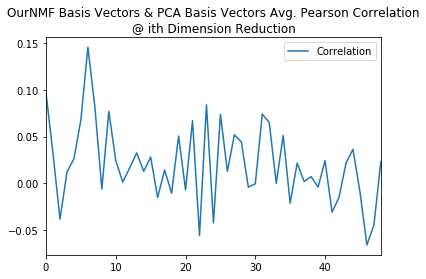

In [19]:
display(l_p_vals[0].plot(title="OurNMF Basis Vectors & PCA Basis Vectors Avg. Pearson Correlation\n@ ith Dimension Reduction"))

Since this graph follows no clear trend, we can conclude that there is no correlation in the basis vectors obtained through PCA dimensionality reduction and NMF dimensionality reduction.

#### **Experiment 1.5: Comparing Approximation**

A large advantage of NMF is that after you get your activation vectors as well as your basis vectors in the form of W and H, you are able to approximate the original input matrix. For our next experiment, let's look at how SKLearn's NMF and OurNMF compare at aproximating a square matrix of size N.

We will use the following function to compare our implementation of NMF to SKLearn's implementation of NMF. The function takes as input a size for the starting matrix. The function will then reduce the starting matrix by one dimension and try to approximate the original input matrix. We measure the average error at aproximating the original matrix for both our implementation and SKLearn's NMF. At each dimensionality reduction iteration, a mean average error is recorded for each respective algorithm. We also record the correlation of each algorithm's transformed activations (H matrix) at each iteration. We are able to visualize the results by plotting the data.

In [20]:
def compare_error(x_size):
    X = generateV(N=x_size)
    N = X.shape[1]
    err_outs = []
    sk_errs = []
    my_errs = []

    for i in range(N - 1, 2, -1): # inclusive range to N
        skl_nmf = NMF(n_components=i, init='random', solver='mu', beta_loss='kullback-leibler')
        sh = skl_nmf.fit_transform(X)
        sw = skl_nmf.components_
        sv = np.matmul(sw.transpose(), sh.transpose())
        
        our_nmf = OurNMF(n_components=i)
        mw, mh = our_nmf.test_fit(pd.DataFrame(X))
        mv = np.matmul(mw.transpose(), mh.transpose())
        err_corr = 0
        err_my = 0
        err_sk = 0
        cnt = 0.0
        for k in range(len(mv[0])):
            err_sk += mean_squared_error(sv[k], X[k])
            err_my += mean_squared_error(mv[k], X[k])
            err_corr += correlate(mh[k], sh[k])
            cnt += 1
        err_outs.append(err_corr / cnt)
        sk_errs.append(err_sk / cnt)
        my_errs.append(err_my / cnt)
    return my_errs, sk_errs, err_outs

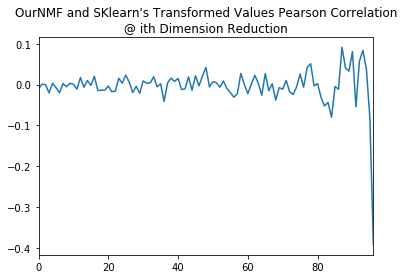

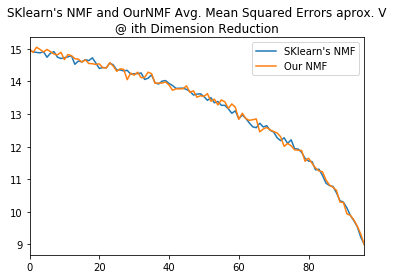

In [27]:
my_errs, sk_errs, err_outs = compare_error(100)
errs_total = pd.DataFrame([sk_errs, my_errs]).transpose()
errs_total.columns = ['SKlearn\'s NMF', 'Our NMF']
pd.Series(err_outs).plot(title="OurNMF and SKlearn's Transformed Values Pearson Correlation\n@ ith Dimension Reduction")
errs_total.plot(title="SKlearn's NMF and OurNMF Avg. Mean Squared Errors aprox. V\n@ ith Dimension Reduction")

After evaluating our generated graphs, we can see that OurNMF algorithm  is doing a good job at aproximating V at each step of the dimensionality reduction iteration judging from how closely OurNMF follows that of SKLearn's NMF. This makes sense given the underlying math of the algorithm is fairly straightforward.

We can also see that the correlation between transformed values of OurNMF and SKLearn's NMF algorithm converges on 0 as we reduce dimensions.

#### **Experiment 2: Resolving the Curse of Dimensionality**
A common problem in machine learning is the "curse of dimensionality" in which, as the number of dimensions of an incoming dataset increases, the prediction performance of a classifier goes down. Inversely, few samples in a dataset makes for poor classifier performance because there is little material for a classifier to form a generalization from. More so, if few features are important (and many features aren't indicative of the prediction target in any way) this makes it even harder for a classifier.

This experiment will aim to create a difficult dataset with the qualities above, and use both our NMF and PCA to perform dimensionality reduction on this dataset. This will then allow a weak classifier to theoretically perform better. This is because dimensionality reduction should hone in on the most important features while it reduces the amount of features.

Let's modify the titanic dataset to make it difficult. We'll begin by pre-processing it into quantitative, non-negative form. We'll be sure to fill in missing values, and scale our data so that no features with large values can unfairly skew the learning of our classifier. Min-max scaling will keep our data in a non-negative range of [0, 1].

In [4]:
from sklearn.preprocessing import MinMaxScaler

titanic_df = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv"
)

titanic_df = titanic_df.drop("name", axis=1)
titanic_df = titanic_df.drop("ticket", axis=1)

# 0) filling missing data
titanic_df = titanic_df.replace([np.inf, -np.inf], np.nan)
titanic_df["age"] = titanic_df["age"].fillna(value=titanic_df["age"].mean())
titanic_df["fare"] = titanic_df["fare"].fillna(value=0.0)

# 1) Scale the quantitative vars
quant_feat = ["age", "sibsp", "parch", "fare"]
scaler = MinMaxScaler()
quant_titanic_df = titanic_df[quant_feat]
quant_titanic_df = pd.DataFrame(scaler.fit_transform(quant_titanic_df), columns=quant_feat)

titanic_df = titanic_df.drop(quant_feat, axis=1)
titanic_df = pd.concat((titanic_df, quant_titanic_df), axis=1)

# 2) Encode catagorical variables to quantitative variables
catagorical_to_quantitative_maps = {}

# pclass
pclass_quant = pd.get_dummies(titanic_df["pclass"])
pclass_quant["pclass 1"] = pclass_quant[1]
pclass_quant = pclass_quant.drop(1, axis=1)
pclass_quant["pclass 2"] = pclass_quant[2]
pclass_quant = pclass_quant.drop(2, axis=1)
pclass_quant["pclass 3"] = pclass_quant[3]
pclass_quant = pclass_quant.drop(3, axis=1)
titanic_df = titanic_df.drop('pclass', axis=1)
titanic_df = pd.concat((titanic_df, pclass_quant), axis=1)

# gender
catagorical_to_quantitative_maps["sex"] = list(titanic_df["sex"].unique())
gender_catagories = pd.DataFrame(pd.get_dummies(titanic_df["sex"]))
titanic_df = titanic_df.drop("sex", axis = 1)
titanic_df= pd.concat([titanic_df, gender_catagories], axis = 1)
   
# boat
titanic_df["boat"] = titanic_df["boat"].fillna(value="No boat")
catagorical_to_quantitative_maps["boat"] = list(titanic_df["boat"].unique())
boat_catagories = pd.DataFrame(pd.get_dummies(titanic_df["boat"]))
titanic_df = titanic_df.drop("boat", axis = 1)
titanic_df = pd.concat([titanic_df, boat_catagories], axis = 1)
# adjust a few columns to aviod running into problems when creating a column with the same name
# will need to consider this when going backwards
titanic_df["boat C"] = titanic_df["C"]
titanic_df = titanic_df.drop("C", axis=1)
catagorical_to_quantitative_maps["boat"].append("boat C")
catagorical_to_quantitative_maps["boat"].remove("C")
titanic_df["boat D"] = titanic_df["D"]
titanic_df = titanic_df.drop("D", axis=1)
catagorical_to_quantitative_maps["boat"].append("boat D")
catagorical_to_quantitative_maps["boat"].remove("D")

#cabin
catagorical_to_quantitative_maps["cabin"] = list(titanic_df["cabin"].unique())
cabins = pd.DataFrame(pd.get_dummies(titanic_df["cabin"]))
titanic_df = titanic_df.drop("cabin", axis = 1)
titanic_df = pd.concat([titanic_df, cabins], axis = 1)

#embarked
titanic_df["embarked"] = titanic_df["embarked"].fillna(value="entrance unknown")
catagorical_to_quantitative_maps["embarked"] = list(titanic_df["embarked"].unique())
entrances = pd.DataFrame(pd.get_dummies(titanic_df["embarked"]))
titanic_df = titanic_df.drop("embarked", axis = 1)
titanic_df = pd.concat([titanic_df, entrances], axis = 1)

#body
titanic_df["body"] = titanic_df["body"].fillna(value="body unknown")
catagorical_to_quantitative_maps["body"] = list(titanic_df["body"].unique())
bodies = pd.DataFrame(pd.get_dummies(titanic_df["body"]))
titanic_df = titanic_df.drop("body", axis = 1)
titanic_df = pd.concat([titanic_df, bodies], axis = 1)

#home.dest
titanic_df["home.dest"] = titanic_df["home.dest"].fillna(value="home.dest unknown")
catagorical_to_quantitative_maps["home.dest"] = list(titanic_df["home.dest"].unique())
destinations = pd.DataFrame(pd.get_dummies(titanic_df["home.dest"]))
titanic_df = titanic_df.drop("home.dest", axis = 1)
titanic_df = pd.concat([titanic_df, destinations], axis = 1)

# Put class labels on the end
survived = titanic_df['survived']
titanic_df = titanic_df.drop('survived', axis=1)
titanic_df = pd.concat((titanic_df, survived), axis=1)

display(titanic_df.shape)
titanic_df.head()

(1309, 720)

,age,sibsp,parch,fare,pclass 1,pclass 2,pclass 3,female,male,1,...,"Winnipeg, MB","Winnipeg, MN","Woodford County, KY","Worcester, England","Worcester, MA","Yoevil, England / Cottage Grove, OR","Youngstown, OH","Zurich, Switzerland",home.dest unknown,survived
0,0.361169,0.000,0.000000,0.412503,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.009395,0.125,0.222222,0.295806,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0.022964,0.125,0.222222,0.295806,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.373695,0.125,0.222222,0.295806,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.311064,0.125,0.222222,0.295806,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's do ourselves a NMF non-negativity constraint sanity check, and see if we have any negative values in our dataset.

In [5]:
print('Number of neg vals:', (titanic_df < 0).sum().sum())

Number of neg vals: 0


Nope! So, now let's make this dataset hard for a classifier by using a small amount of samples, and adding many unimportant features - these are essentially noise for a classifier.

In [6]:
n_samples = 200
Xy = titanic_df.sample(frac=1.0)[:n_samples]
Xy.index = range(n_samples)

# 3) Put random vars in (already in min-max scale range)
noise = pd.DataFrame(np.random.random(size=(n_samples, 2000)), columns=['noise_f' + str(x) for x in range(2000)])
Xy = pd.concat((noise, Xy), axis=1)

X = Xy.drop('survived', axis=1)
y = Xy['survived']

display(Xy.shape)
Xy.head()

(200, 2720)

,noise_f0,noise_f1,noise_f2,noise_f3,noise_f4,noise_f5,noise_f6,noise_f7,noise_f8,noise_f9,...,"Winnipeg, MB","Winnipeg, MN","Woodford County, KY","Worcester, England","Worcester, MA","Yoevil, England / Cottage Grove, OR","Youngstown, OH","Zurich, Switzerland",home.dest unknown,survived
0,0.662909,0.443931,0.462547,0.296631,0.254183,0.055814,0.850389,0.475527,0.308739,0.648973,...,0,0,0,0,0,0,0,0,1,0
1,0.181717,0.753577,0.678356,0.578486,0.241781,0.301081,0.674126,0.802209,0.470562,0.035503,...,0,0,0,0,0,0,0,0,1,0
2,0.089699,0.230864,0.665112,0.854662,0.423910,0.657349,0.857774,0.349233,0.190625,0.840201,...,0,0,0,0,0,0,0,0,1,0
3,0.735099,0.174886,0.857334,0.663739,0.674032,0.930980,0.832422,0.053184,0.763767,0.563166,...,0,0,0,0,0,0,0,0,1,1
4,0.782754,0.829165,0.378733,0.824815,0.540076,0.943269,0.802357,0.576927,0.827647,0.423430,...,0,0,0,0,0,0,0,0,0,0


Now we will get an accuracy measurement when we feed the entire dataset into a simple classifer: Logistic Regression.

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


def logreg_acc(X, y, pred_iterations=30):
    accs = []
    logreg_model = LogisticRegression()
    for _ in range(pred_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        logreg_model.fit(X_train, y_train)
        y_pred = logreg_model.predict(X_test)

        acc_score = accuracy_score(y_pred, y_test)
        accs.append(acc_score)

    return np.mean(accs)

print('Logistic Regression Avg. Accuracy Score for Titanic Dataset (Bad):', logreg_acc(X, y))

Logistic Regression Avg. Accuracy Score for Titanic Dataset (Bad): 0.8306666666666668


Accuracy of ~90% might seem okay, but if this were in use today we would still incorrectly predict 1/10 subjects which isn't reliable. Let's see if reducing dimension gives us performance gains, by doing this same thing over a number of dimensions. This might take 5-10 minutes.

In [8]:
from sklearn.decomposition import PCA
# Solution: simple classifiers can handle these datasets better, after dimensionality reduction is applied
# If we reduce dimensions on a dataset via NMF & sklearn PCA, and then predict at each dimension drop, does lin. reg. performance increase?

def logreg_acc_for_nmf_pca(X, y, min_dim=2, pred_iterations=30):
    dim_nmf_accs, dim_pca_accs = [], []
    # Num of dim must be <= min dimension of our X for sklearn NMF
    dim_iterations = range(min_dim, min(X.shape) + 1, 10)

    # Track how prediction performance differs with amount of dimensions
    for dim_num in dim_iterations: 

        # Perform PCA and NMF on same dataset
        nmf_model = OurNMF(n_components=dim_num)
        X_nmftrans = pd.DataFrame(nmf_model.fit_transform(X))
        pca_model = PCA(n_components=dim_num)
        X_pcatrans = pd.DataFrame(pca_model.fit_transform(X))

        nmf_acc = logreg_acc(X_nmftrans, y, pred_iterations=pred_iterations)
        pca_acc = logreg_acc(X_pcatrans, y, pred_iterations=pred_iterations)

        dim_nmf_accs.append(nmf_acc)
        dim_pca_accs.append(pca_acc)

    nmf_logreg_accs = pd.Series(dim_nmf_accs)
    pca_logreg_accs = pd.Series(dim_pca_accs)
    nmf_logreg_accs.index = dim_iterations
    pca_logreg_accs.index = dim_iterations
    
    return nmf_logreg_accs, pca_logreg_accs

nmf_logreg_accs, pca_logreg_accs = logreg_acc_for_nmf_pca(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


Text(0.5, 0, 'Dimensions')

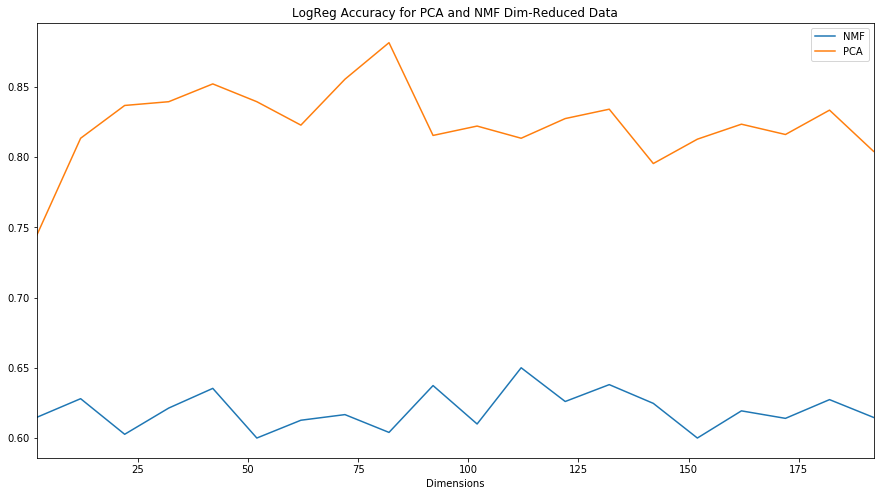

In [9]:
nmf_logreg_accs.plot.line(title='LogReg Accuracy for PCA and NMF Dim-Reduced Data', legend=True, label='NMF', figsize=(15,8))
ax = pca_logreg_accs.plot.line(legend=True, label='PCA')
ax.set_xlabel("Dimensions")

It seems like any trend in performance is hard to see here.

#### **Let's try a more NMF-appropriate dataset: Wine**
NMF is overall better suited for naturally non-negative and quantitative data. This data can be thought of as from "physical" measurements, like audio and picture data for example.

In [10]:
scaler = MinMaxScaler()

reds_df = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/reds.csv", 
    delimiter=';'
)
reds_df = pd.DataFrame(scaler.fit_transform(reds_df), columns=reds_df.columns)
reds_df['class'] = 1
whites_df = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/whites.csv", 
    delimiter=';'
)
whites_df = pd.DataFrame(scaler.fit_transform(whites_df), columns=whites_df.columns)
whites_df['class'] = 0

n_samples = 200
reds_df = reds_df.sample(frac=1.0)[:n_samples // 2]
whites_df = whites_df.sample(frac=1.0)[:n_samples // 2]

Xy = pd.concat((reds_df, whites_df), axis=0).sample(frac=1.0)
Xy.index = range(n_samples)

# Put random vars in (already in min-max scale range)
noise = pd.DataFrame(np.random.random(size=(n_samples, 2000)), columns=['noise_f' + str(x) for x in range(2000)])
Xy = pd.concat((noise, Xy), axis=1)

X = Xy.drop('class', axis=1)
y = Xy['class']

display(Xy.shape)
Xy.head()

(200, 2013)

,noise_f0,noise_f1,noise_f2,noise_f3,noise_f4,noise_f5,noise_f6,noise_f7,noise_f8,noise_f9,...,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,0.064220,0.728601,0.176392,0.170493,0.335472,0.948288,0.740150,0.407161,0.544084,0.600396,...,0.047945,0.100167,0.225352,0.127208,0.406021,0.496063,0.089820,0.092308,0.200000,1
1,0.149934,0.354719,0.430805,0.664133,0.046774,0.752788,0.056671,0.279760,0.681627,0.004791,...,0.256135,0.124629,0.052265,0.324826,0.217660,0.254545,0.244186,0.225806,0.500000,0
2,0.982050,0.817961,0.516397,0.767711,0.630847,0.229124,0.449084,0.431384,0.855092,0.648402,...,0.194785,0.130564,0.160279,0.429234,0.198381,0.336364,0.267442,0.225806,0.333333,0
3,0.178180,0.002649,0.991157,0.689588,0.246285,0.764447,0.384326,0.617005,0.688665,0.088804,...,0.133562,0.136895,0.478873,0.353357,0.596916,0.283465,0.119760,0.123077,0.400000,1
4,0.769153,0.016925,0.083958,0.769115,0.282769,0.041939,0.850215,0.289665,0.038675,0.777346,...,0.199387,0.121662,0.132404,0.368910,0.202236,0.318182,0.348837,0.258065,0.666667,0


In [11]:
print('Logistic Regression Average Accuracy Score for Wines Dataset (Bad):', logreg_acc(X, y))

Logistic Regression Average Accuracy Score for Wines Dataset (Bad): 0.5166666666666667


Weak classifier performance is bad as expected. Will dimensionality reduction help now? This again may take 5-10 minutes.

In [12]:
nmf_logreg_accs, pca_logreg_accs = logreg_acc_for_nmf_pca(X, y)

Text(0.5, 0, 'Dimensions')

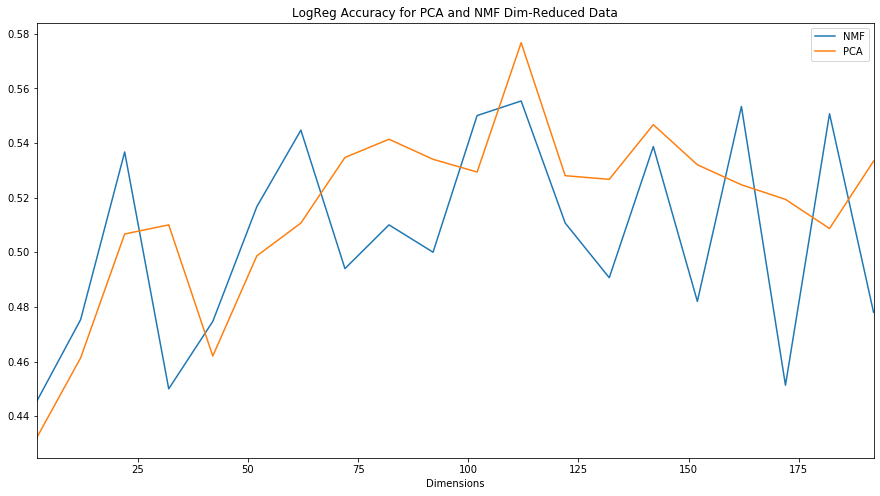

In [13]:
nmf_logreg_accs.plot.line(title='LogReg Accuracy for PCA and NMF Dim-Reduced Data', legend=True, label='NMF', figsize=(15,8))
ax = pca_logreg_accs.plot.line(legend=True, label='PCA')
ax.set_xlabel("Dimensions")

So it looks like as our dimensions are lowered, there is a subtle trend towards higher accuracy. Interestingly, NMF seems to have greater varying accuracy over a range of dimensions than PCA. PCA seems to yield a more constant high accuracy. This is most likely because PCA finds the most descriptive features to have a say in any number of dimensions, while NMF shouldn't weight any features higher than others in a dimension reduction. On that bombshell, thanks for joining us on our adventure into NMF.